In [8]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [28]:
task = "patho_and_likelypatho" 
negative_cls = "neutral"
positive_cls = "likely_pathogenic" # pathogenic, likely_pathogenic
n_samples = 1000
# model_root_and_name_tuple_list = [("", "random_classifier"), ("", "conservation")]
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("vespa_marquet", "vespal"), 
                                  ("", "random_classifier"), ("", "conservation")]

# by default, we consider larger means positive class (here pathogenic or likely-pathogenic), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [29]:
columns = ['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
            'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
            'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
            'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
            'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
            'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
            'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
            'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
            'prottrans_t5_xl_u50_pred', 'vespal_pred', 'conservation_pred']

patho_and_likelypatho_result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis.csv", sep="\t")
patho_and_likelypatho_result_df = patho_and_likelypatho_result_df.rename(columns={"clinvar_id":"id"})
patho_and_likelypatho_result_df = patho_and_likelypatho_result_df[columns]


popu_freq_result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/popu_freq_analysis.csv", sep="\t")
popu_freq_result_df = popu_freq_result_df[(popu_freq_result_df["class"]=="Common") | (popu_freq_result_df["class"]=="Rare")]
popu_freq_result_df["class"] = negative_cls
popu_freq_result_df = popu_freq_result_df.rename(columns={"snp_id":"id"})
popu_freq_result_df = popu_freq_result_df[columns]


patho_and_likelypatho_result_df_unique_prots_list = patho_and_likelypatho_result_df["prot_acc_version"].unique()
popu_freq_result_df = popu_freq_result_df[popu_freq_result_df["prot_acc_version"].isin(patho_and_likelypatho_result_df_unique_prots_list)] # variants must be of same proteins/genes from patho_and_likelypatho

print(popu_freq_result_df.shape)
print(popu_freq_result_df.columns)

print(patho_and_likelypatho_result_df.shape)
print(patho_and_likelypatho_result_df.columns)

result_df = pd.concat([popu_freq_result_df, patho_and_likelypatho_result_df])

(3639, 31)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred', 'vespal_pred', 'conservation_pred'],
      dtype='object')
(6476, 31)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_p

### Computing all methods performance metrics

In [37]:
def get_non_nan_df(df, col_name):
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls]
    negative_cls_result_df = df[df["class"]==negative_cls]
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0

    positive_cls_unique_prots_list = positive_cls_result_df["prot_acc_version"].unique()
    negative_cls_result_df = negative_cls_result_df[negative_cls_result_df["prot_acc_version"].isin(positive_cls_unique_prots_list)] # variants must be of same proteins/genes from patho_and_likelypatho
    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")

    positive_cls_result_df = positive_cls_result_df.sample(n=n_samples)
    negative_cls_result_df = negative_cls_result_df.sample(n=n_samples)
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

def get_pathogenic_analysis_threshold(model_name):
    patho_performance_metrics_df = pd.read_csv(home_dir+f"models/aa_common/performance_analysis/{task}_pathogenic_vs_{negative_cls}_analysis.csv", sep="\t")
    patho_th_max = patho_performance_metrics_df[patho_performance_metrics_df["Models\\Metrics"]==model_name]["Th-max"].values[1]
    patho_th_max = patho_th_max.split('(')[0]
    patho_th_max = float(patho_th_max)
    print(f"\tComputed th from pathogenic-analysis: {patho_th_max}")
    return patho_th_max


In [38]:
performance_scores_dict = {}

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"

    performance_scores = []

    for i_run in range(10): #10 runs
        sampled_result_df = sample_positive_and_negative_data_points(result_df)
            
        if model_name=="random_classifier": sampled_result_df[model_pred_col] = [random.uniform(0, 1) for i in range(sampled_result_df.shape[0])]
        
        sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
        
        non_nan_result_df, missing_values_percentage = get_non_nan_df(sampled_result_df, model_pred_col)
        
        non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
        
        ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
        auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
        f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

        if positive_cls=="likely_pathogenic": th_max =  get_pathogenic_analysis_threshold(model_name)
        
        precision = get_precision_score(non_nan_result_df, th_max)
        recall = get_recall_score(non_nan_result_df, th_max)
        accuracy = get_accuracy_score(non_nan_result_df, th_max)
        balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
        mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
        
        performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage])
        print()
            
    performance_scores_dict[model_name] = performance_scores
# performance_scores_dict

sift
	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*301/2000=15.049999999999999
	AUC-ROC: 0.866
	KS-test score. statistic: 0.604, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.812 at threshold: -0.020
	Computed th from pathogenic-analysis: -0.026
	Precision score: 0.773 at threshold: -0.026
	Recall score: 0.854 at threshold: -0.026
	Accuracy score: 0.798 at threshold: -0.026
	Balanced accuracy score: 0.796 at threshold: -0.026
	MCC score: 0.597 at threshold: -0.026

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*310/2000=15.5
	AUC-ROC: 0.867
	KS-test score. statistic: 0.594, p-value: 0.000
	AUC-PR: 0.869
	Best F1-Score: 0.806 at threshold: -0.024
	Computed th from pathogenic-analysis: -0.026
	Precision score: 0.777 at threshold: -0.026
	Recall score: 0.835 at threshold: -0.026
	Accuracy score: 0.794 at threshold: -0.026
	Balanced accuracy score: 0.793 at threshold: -0.026
	MCC score: 0.589 at threshold: -0.026

	

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Missing values: 100*298/2000=14.899999999999999
	AUC-ROC: 0.853
	KS-test score. statistic: 0.572, p-value: 0.000
	AUC-PR: 0.854
	Best F1-Score: 0.794 at threshold: -0.044
	Computed th from pathogenic-analysis: -0.026
	Precision score: 0.762 at threshold: -0.026
	Recall score: 0.824 at threshold: -0.026
	Accuracy score: 0.780 at threshold: -0.026
	Balanced accuracy score: 0.779 at threshold: -0.026
	MCC score: 0.561 at threshold: -0.026

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*315/2000=15.75
	AUC-ROC: 0.857
	KS-test score. statistic: 0.578, p-value: 0.000
	AUC-PR: 0.854
	Best F1-Score: 0.807 at threshold: -0.044
	Computed th from pathogenic-analysis: -0.026
	Precision score: 0.765 at threshold: -0.026
	Recall score: 0.844 at threshold: -0.026
	Accuracy score: 0.790 at threshold: -0.026
	Balanced accuracy score: 0.789 at threshold: -0.026
	MCC score: 0.582 at threshold: -0.026

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Miss

/tmp/ipykernel_2447246/3584865344.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

	Precision score: 0.763 at threshold: -0.026
	Recall score: 0.851 at threshold: -0.026
	Accuracy score: 0.792 at threshold: -0.026
	Balanced accuracy score: 0.791 at threshold: -0.026
	MCC score: 0.587 at threshold: -0.026

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*333/2000=16.650000000000002
	AUC-ROC: 0.864
	KS-test score. statistic: 0.596, p-value: 0.000
	AUC-PR: 0.861
	Best F1-Score: 0.808 at threshold: -0.033
	Computed th from pathogenic-analysis: -0.026
	Precision score: 0.762 at threshold: -0.026
	Recall score: 0.858 at threshold: -0.026
	Accuracy score: 0.791 at threshold: -0.026
	Balanced accuracy score: 0.789 at threshold: -0.026
	MCC score: 0.585 at threshold: -0.026

polyphen2_HVAR
	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*342/2000=17.1
	AUC-ROC: 0.849
	KS-test score. statistic: 0.558, p-value: 0.000
	AUC-PR: 0.835
	Best F1-Score: 0.803 at threshold: 0.366
	Computed th from pathogenic-analysis:

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Balanced accuracy score: 0.790 at threshold: 0.524
	MCC score: 0.589 at threshold: 0.524

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*374/2000=18.7
	AUC-ROC: 0.853
	KS-test score. statistic: 0.574, p-value: 0.000
	AUC-PR: 0.836
	Best F1-Score: 0.812 at threshold: 0.256
	Computed th from pathogenic-analysis: 0.524
	Precision score: 0.758 at threshold: 0.524
	Recall score: 0.859 at threshold: 0.524
	Accuracy score: 0.788 at threshold: 0.524
	Balanced accuracy score: 0.786 at threshold: 0.524
	MCC score: 0.580 at threshold: 0.524

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*354/2000=17.7
	AUC-ROC: 0.846
	KS-test score. statistic: 0.556, p-value: 0.000
	AUC-PR: 0.831
	Best F1-Score: 0.799 at threshold: 0.404
	Computed th from pathogenic-analysis: 0.524
	Precision score: 0.749 at threshold: 0.524
	Recall score: 0.841 at threshold: 0.524
	Accuracy score: 0.776 at threshold: 0.524
	Balanced accuracy score: 0.775 at

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	AUC-PR: 0.837
	Best F1-Score: 0.836 at threshold: 0.470
	Computed th from pathogenic-analysis: 0.471
	Precision score: 0.766 at threshold: 0.471
	Recall score: 0.917 at threshold: 0.471
	Accuracy score: 0.814 at threshold: 0.471
	Balanced accuracy score: 0.811 at threshold: 0.471
	MCC score: 0.639 at threshold: 0.471

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*257/2000=12.85
	AUC-ROC: 0.858
	KS-test score. statistic: 0.579, p-value: 0.000
	AUC-PR: 0.825
	Best F1-Score: 0.817 at threshold: 0.520
	Computed th from pathogenic-analysis: 0.471
	Precision score: 0.666 at threshold: 0.471
	Recall score: 0.971 at threshold: 0.471
	Accuracy score: 0.738 at threshold: 0.471
	Balanced accuracy score: 0.735 at threshold: 0.471
	MCC score: 0.535 at threshold: 0.471

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*266/2000=13.3
	AUC-ROC: 0.857
	KS-test score. statistic: 0.591, p-value: 0.000
	AUC-PR: 0.804
	Best F1-Score: 0.

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Balanced accuracy score: 0.788 at threshold: 0.471
	MCC score: 0.600 at threshold: 0.471

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*266/2000=13.3
	AUC-ROC: 0.875
	KS-test score. statistic: 0.610, p-value: 0.000
	AUC-PR: 0.832
	Best F1-Score: 0.829 at threshold: 0.425
	Computed th from pathogenic-analysis: 0.471
	Precision score: 0.766 at threshold: 0.471
	Recall score: 0.880 at threshold: 0.471
	Accuracy score: 0.802 at threshold: 0.471
	Balanced accuracy score: 0.801 at threshold: 0.471
	MCC score: 0.610 at threshold: 0.471

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*244/2000=12.2
	AUC-ROC: 0.858
	KS-test score. statistic: 0.577, p-value: 0.000
	AUC-PR: 0.819
	Best F1-Score: 0.815 at threshold: 0.504
	Computed th from pathogenic-analysis: 0.471
	Precision score: 0.701 at threshold: 0.471
	Recall score: 0.950 at threshold: 0.471
	Accuracy score: 0.767 at threshold: 0.471
	Balanced accuracy score: 0.763 at

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Computed th from pathogenic-analysis: 0.683
	Precision score: 0.701 at threshold: 0.683
	Recall score: 0.911 at threshold: 0.683
	Accuracy score: 0.715 at threshold: 0.683
	Balanced accuracy score: 0.667 at threshold: 0.683
	MCC score: 0.394 at threshold: 0.683

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*500/2000=25.0
	AUC-ROC: 0.806
	KS-test score. statistic: 0.508, p-value: 0.000
	AUC-PR: 0.836
	Best F1-Score: 0.804 at threshold: 0.845
	Computed th from pathogenic-analysis: 0.683
	Precision score: 0.698 at threshold: 0.683
	Recall score: 0.916 at threshold: 0.683
	Accuracy score: 0.713 at threshold: 0.683
	Balanced accuracy score: 0.663 at threshold: 0.683
	MCC score: 0.389 at threshold: 0.683

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*518/2000=25.900000000000002
	AUC-ROC: 0.800
	KS-test score. statistic: 0.496, p-value: 0.000
	AUC-PR: 0.829
	Best F1-Score: 0.806 at threshold: 0.761
	Computed th from pa

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	KS-test score. statistic: 0.916, p-value: 0.000
	AUC-PR: 0.972
	Best F1-Score: 0.960 at threshold: 0.233
	Computed th from pathogenic-analysis: 0.263
	Precision score: 0.944 at threshold: 0.263
	Recall score: 0.974 at threshold: 0.263
	Accuracy score: 0.957 at threshold: 0.263
	Balanced accuracy score: 0.957 at threshold: 0.263
	MCC score: 0.915 at threshold: 0.263

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*244/2000=12.2
	AUC-ROC: 0.982
	KS-test score. statistic: 0.916, p-value: 0.000
	AUC-PR: 0.969
	Best F1-Score: 0.960 at threshold: 0.281
	Computed th from pathogenic-analysis: 0.263
	Precision score: 0.936 at threshold: 0.263
	Recall score: 0.982 at threshold: 0.263
	Accuracy score: 0.957 at threshold: 0.263
	Balanced accuracy score: 0.956 at threshold: 0.263
	MCC score: 0.915 at threshold: 0.263

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*274/2000=13.700000000000001
	AUC-ROC: 0.980
	KS-test score. stat

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Precision score: 0.924 at threshold: 0.263
	Recall score: 0.985 at threshold: 0.263
	Accuracy score: 0.951 at threshold: 0.263
	Balanced accuracy score: 0.951 at threshold: 0.263
	MCC score: 0.904 at threshold: 0.263

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*273/2000=13.65
	AUC-ROC: 0.975
	KS-test score. statistic: 0.906, p-value: 0.000
	AUC-PR: 0.955
	Best F1-Score: 0.955 at threshold: 0.296
	Computed th from pathogenic-analysis: 0.263
	Precision score: 0.921 at threshold: 0.263
	Recall score: 0.986 at threshold: 0.263
	Accuracy score: 0.950 at threshold: 0.263
	Balanced accuracy score: 0.950 at threshold: 0.263
	MCC score: 0.903 at threshold: 0.263

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*260/2000=13.0
	AUC-ROC: 0.982
	KS-test score. statistic: 0.924, p-value: 0.000
	AUC-PR: 0.976
	Best F1-Score: 0.964 at threshold: 0.262
	Computed th from pathogenic-analysis: 0.263
	Precision score: 0.943 at thresh

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*299/2000=14.95
	AUC-ROC: 0.909
	KS-test score. statistic: 0.689, p-value: 0.000
	AUC-PR: 0.888
	Best F1-Score: 0.854 at threshold: 0.536
	Computed th from pathogenic-analysis: 0.427
	Precision score: 0.788 at threshold: 0.427
	Recall score: 0.913 at threshold: 0.427
	Accuracy score: 0.829 at threshold: 0.427
	Balanced accuracy score: 0.827 at threshold: 0.427
	MCC score: 0.665 at threshold: 0.427

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*291/2000=14.549999999999999
	AUC-ROC: 0.911
	KS-test score. statistic: 0.694, p-value: 0.000
	AUC-PR: 0.904
	Best F1-Score: 0.854 at threshold: 0.516
	Computed th from pathogenic-analysis: 0.427
	Precision score: 0.787 at threshold: 0.427
	Recall score: 0.914 at threshold: 0.427
	Accuracy score: 0.827 at threshold: 0.427
	Balanced accuracy score: 0.824 at threshold: 0.427
	MCC score: 0.662 at threshold: 0.427

	likely_pathogenic(

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	AUC-ROC: 0.900
	KS-test score. statistic: 0.666, p-value: 0.000
	AUC-PR: 0.888
	Best F1-Score: 0.844 at threshold: 0.457
	Computed th from pathogenic-analysis: 0.427
	Precision score: 0.774 at threshold: 0.427
	Recall score: 0.913 at threshold: 0.427
	Accuracy score: 0.819 at threshold: 0.427
	Balanced accuracy score: 0.816 at threshold: 0.427
	MCC score: 0.647 at threshold: 0.427

unirep
	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.527
	KS-test score. statistic: 0.110, p-value: 0.000
	AUC-PR: 0.547
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.096
	Precision score: 0.500 at threshold: -0.096
	Recall score: 1.000 at threshold: -0.096
	Accuracy score: 0.500 at threshold: -0.096
	Balanced accuracy score: 0.500 at threshold: -0.096
	MCC score: 0.000 at threshold: -0.096

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.538
	KS-test sc

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.530
	KS-test score. statistic: 0.109, p-value: 0.000
	AUC-PR: 0.553
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.096
	Precision score: 0.500 at threshold: -0.096
	Recall score: 1.000 at threshold: -0.096
	Accuracy score: 0.500 at threshold: -0.096
	Balanced accuracy score: 0.500 at threshold: -0.096
	MCC score: 0.000 at threshold: -0.096

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.537
	KS-test score. statistic: 0.097, p-value: 0.000
	AUC-PR: 0.546
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.096
	Precision score: 0.500 at threshold: -0.096
	Recall score: 1.000 at threshold: -0.096
	Accuracy score: 0.500 at threshold: -0.096
	Balanced accuracy score: 0.500 at threshold: -0.096
	MCC score: 0.000 at threshold: -0.096

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	KS-test score. statistic: 0.072, p-value: 0.011
	AUC-PR: 0.545
	Best F1-Score: 0.667 at threshold: -0.920
	Computed th from pathogenic-analysis: -0.865
	Precision score: 0.500 at threshold: -0.865
	Recall score: 0.993 at threshold: -0.865
	Accuracy score: 0.499 at threshold: -0.865
	Balanced accuracy score: 0.499 at threshold: -0.865
	MCC score: -0.006 at threshold: -0.865

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.464
	KS-test score. statistic: 0.079, p-value: 0.004
	AUC-PR: 0.568
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.865
	Precision score: 0.500 at threshold: -0.865
	Recall score: 0.997 at threshold: -0.865
	Accuracy score: 0.500 at threshold: -0.865
	Balanced accuracy score: 0.500 at threshold: -0.865
	MCC score: 0.008 at threshold: -0.865

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.460
	KS-test score. statistic

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	KS-test score. statistic: 0.231, p-value: 0.000
	AUC-PR: 0.625
	Best F1-Score: 0.676 at threshold: 0.010
	Computed th from pathogenic-analysis: 0.061
	Precision score: 0.556 at threshold: 0.061
	Recall score: 0.798 at threshold: 0.061
	Accuracy score: 0.580 at threshold: 0.061
	Balanced accuracy score: 0.580 at threshold: 0.061
	MCC score: 0.178 at threshold: 0.061

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*4/2000=0.2
	AUC-ROC: 0.350
	KS-test score. statistic: 0.239, p-value: 0.000
	AUC-PR: 0.636
	Best F1-Score: 0.678 at threshold: 0.022
	Computed th from pathogenic-analysis: 0.061
	Precision score: 0.567 at threshold: 0.061
	Recall score: 0.811 at threshold: 0.061
	Accuracy score: 0.595 at threshold: 0.061
	Balanced accuracy score: 0.595 at threshold: 0.061
	MCC score: 0.211 at threshold: 0.061

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*1/2000=0.05
	AUC-ROC: 0.355
	KS-test score. statistic: 0.240, p-val

/tmp/ipykernel_2447246/3584865344.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

	Computed th from pathogenic-analysis: 0.061
	Precision score: 0.556 at threshold: 0.061
	Recall score: 0.794 at threshold: 0.061
	Accuracy score: 0.580 at threshold: 0.061
	Balanced accuracy score: 0.579 at threshold: 0.061
	MCC score: 0.176 at threshold: 0.061

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*5/2000=0.25
	AUC-ROC: 0.342
	KS-test score. statistic: 0.261, p-value: 0.000
	AUC-PR: 0.658
	Best F1-Score: 0.675 at threshold: 0.018
	Computed th from pathogenic-analysis: 0.061
	Precision score: 0.567 at threshold: 0.061
	Recall score: 0.809 at threshold: 0.061
	Accuracy score: 0.595 at threshold: 0.061
	Balanced accuracy score: 0.595 at threshold: 0.061
	MCC score: 0.211 at threshold: 0.061

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*3/2000=0.15
	AUC-ROC: 0.363
	KS-test score. statistic: 0.222, p-value: 0.000
	AUC-PR: 0.622
	Best F1-Score: 0.670 at threshold: 0.011
	Computed th from pathogenic-analysis:

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	MCC score: 0.558 at threshold: -0.529

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.149
	KS-test score. statistic: 0.562, p-value: 0.000
	AUC-PR: 0.832
	Best F1-Score: 0.789 at threshold: -0.550
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.728 at threshold: -0.529
	Recall score: 0.852 at threshold: -0.529
	Accuracy score: 0.766 at threshold: -0.529
	Balanced accuracy score: 0.766 at threshold: -0.529
	MCC score: 0.541 at threshold: -0.529

esm1v_t33_650M_UR90S
	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.145
	KS-test score. statistic: 0.581, p-value: 0.000
	AUC-PR: 0.849
	Best F1-Score: 0.799 at threshold: -0.607
	Computed th from pathogenic-analysis: -0.508
	Precision score: 0.826 at threshold: -0.508
	Recall score: 0.665 at threshold: -0.508
	Accuracy score: 0.762 at threshold: -0.508
	Balanced accuracy score: 0.762 at threshold: -0.508
	MCC 

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Recall score: 0.721 at threshold: -0.508
	Accuracy score: 0.775 at threshold: -0.508
	Balanced accuracy score: 0.775 at threshold: -0.508
	MCC score: 0.553 at threshold: -0.508

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.161
	KS-test score. statistic: 0.570, p-value: 0.000
	AUC-PR: 0.832
	Best F1-Score: 0.793 at threshold: -0.596
	Computed th from pathogenic-analysis: -0.508
	Precision score: 0.823 at threshold: -0.508
	Recall score: 0.650 at threshold: -0.508
	Accuracy score: 0.755 at threshold: -0.508
	Balanced accuracy score: 0.755 at threshold: -0.508
	MCC score: 0.522 at threshold: -0.508

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.160
	KS-test score. statistic: 0.563, p-value: 0.000
	AUC-PR: 0.827
	Best F1-Score: 0.794 at threshold: -0.556
	Computed th from pathogenic-analysis: -0.508
	Precision score: 0.789 at threshold: -0.508
	Recall score: 0.757 at th

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	AUC-PR: 0.833
	Best F1-Score: 0.781 at threshold: -0.452
	Computed th from pathogenic-analysis: -0.434
	Precision score: 0.746 at threshold: -0.434
	Recall score: 0.811 at threshold: -0.434
	Accuracy score: 0.767 at threshold: -0.434
	Balanced accuracy score: 0.768 at threshold: -0.434
	MCC score: 0.537 at threshold: -0.434

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.161
	KS-test score. statistic: 0.547, p-value: 0.000
	AUC-PR: 0.834
	Best F1-Score: 0.782 at threshold: -0.466
	Computed th from pathogenic-analysis: -0.434
	Precision score: 0.771 at threshold: -0.434
	Recall score: 0.776 at threshold: -0.434
	Accuracy score: 0.772 at threshold: -0.434
	Balanced accuracy score: 0.772 at threshold: -0.434
	MCC score: 0.545 at threshold: -0.434

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.179
	KS-test score. statistic: 0.524, p-value: 0.000
	AUC-PR: 0.826
	Best F1-Sc

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.179
	KS-test score. statistic: 0.537, p-value: 0.000
	AUC-PR: 0.815
	Best F1-Score: 0.771 at threshold: -0.468
	Computed th from pathogenic-analysis: -0.434
	Precision score: 0.779 at threshold: -0.434
	Recall score: 0.750 at threshold: -0.434
	Accuracy score: 0.768 at threshold: -0.434
	Balanced accuracy score: 0.768 at threshold: -0.434
	MCC score: 0.537 at threshold: -0.434

plus_rnn
	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.450
	KS-test score. statistic: 0.138, p-value: 0.000
	AUC-PR: 0.604
	Best F1-Score: 0.667 at threshold: -0.975
	Computed th from pathogenic-analysis: -0.931
	Precision score: 0.499 at threshold: -0.931
	Recall score: 0.997 at threshold: -0.931
	Accuracy score: 0.499 at threshold: -0.931
	Balanced accuracy score: 0.499 at threshold: -0.931
	MCC score: -0.022 at threshold: -0.931

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values:

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.448
	KS-test score. statistic: 0.129, p-value: 0.000
	AUC-PR: 0.600
	Best F1-Score: 0.668 at threshold: -0.781
	Computed th from pathogenic-analysis: -0.931
	Precision score: 0.500 at threshold: -0.931
	Recall score: 1.000 at threshold: -0.931
	Accuracy score: 0.500 at threshold: -0.931
	Balanced accuracy score: 0.500 at threshold: -0.931
	MCC score: 0.022 at threshold: -0.931

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.461
	KS-test score. statistic: 0.109, p-value: 0.000
	AUC-PR: 0.586
	Best F1-Score: 0.667 at threshold: -0.897
	Computed th from pathogenic-analysis: -0.931
	Precision score: 0.500 at threshold: -0.931
	Recall score: 1.000 at threshold: -0.931
	Accuracy score: 0.500 at threshold: -0.931
	Balanced accuracy score: 0.500 at threshold: -0.931
	MCC score: 0.022 at threshold: -0.931

	likely_pathogenic(+ve): (

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.186
	KS-test score. statistic: 0.542, p-value: 0.000
	AUC-PR: 0.808
	Best F1-Score: 0.766 at threshold: -0.549
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.792 at threshold: -0.529
	Recall score: 0.728 at threshold: -0.529
	Accuracy score: 0.768 at threshold: -0.529
	Balanced accuracy score: 0.768 at threshold: -0.529
	MCC score: 0.539 at threshold: -0.529

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.189
	KS-test score. statistic: 0.526, p-value: 0.000
	AUC-PR: 0.806
	Best F1-Score: 0.761 at threshold: -0.551
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.760 at threshold: -0.529
	Recall score: 0.758 at threshold: -0.529
	Accuracy score: 0.759 at threshold: -0.529
	Balanced accuracy score: 0.759 at threshold: -0.529
	MCC score: 0.518 at threshold: -0.529

	likely_pathogenic(+ve): (

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	MCC score: 0.500 at threshold: -0.529

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.185
	KS-test score. statistic: 0.537, p-value: 0.000
	AUC-PR: 0.808
	Best F1-Score: 0.768 at threshold: -0.499
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.732 at threshold: -0.529
	Recall score: 0.794 at threshold: -0.529
	Accuracy score: 0.751 at threshold: -0.529
	Balanced accuracy score: 0.752 at threshold: -0.529
	MCC score: 0.505 at threshold: -0.529

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.182
	KS-test score. statistic: 0.548, p-value: 0.000
	AUC-PR: 0.816
	Best F1-Score: 0.769 at threshold: -0.475
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.679 at threshold: -0.529
	Recall score: 0.850 at threshold: -0.529
	Accuracy score: 0.725 at threshold: -0.529
	Balanced accuracy score: 0.724 at threshold: -0.529
	MCC score: 0.464 at thres

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Recall score: 0.853 at threshold: -0.502
	Accuracy score: 0.758 at threshold: -0.502
	Balanced accuracy score: 0.758 at threshold: -0.502
	MCC score: 0.526 at threshold: -0.502

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.180
	KS-test score. statistic: 0.530, p-value: 0.000
	AUC-PR: 0.811
	Best F1-Score: 0.773 at threshold: -0.405
	Computed th from pathogenic-analysis: -0.502
	Precision score: 0.636 at threshold: -0.502
	Recall score: 0.904 at threshold: -0.502
	Accuracy score: 0.693 at threshold: -0.502
	Balanced accuracy score: 0.693 at threshold: -0.502
	MCC score: 0.426 at threshold: -0.502

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.170
	KS-test score. statistic: 0.540, p-value: 0.000
	AUC-PR: 0.816
	Best F1-Score: 0.783 at threshold: -0.459
	Computed th from pathogenic-analysis: -0.502
	Precision score: 0.674 at threshold: -0.502
	Recall score: 0.888 at th

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Accuracy score: 0.499 at threshold: -0.992
	Balanced accuracy score: 0.499 at threshold: -0.992
	MCC score: -0.022 at threshold: -0.992

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.387
	KS-test score. statistic: 0.237, p-value: 0.000
	AUC-PR: 0.663
	Best F1-Score: 0.667 at threshold: -0.877
	Computed th from pathogenic-analysis: -0.992
	Precision score: 0.500 at threshold: -0.992
	Recall score: 0.999 at threshold: -0.992
	Accuracy score: 0.499 at threshold: -0.992
	Balanced accuracy score: 0.499 at threshold: -0.992
	MCC score: -0.022 at threshold: -0.992

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.406
	KS-test score. statistic: 0.224, p-value: 0.000
	AUC-PR: 0.646
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.992
	Precision score: 0.500 at threshold: -0.992
	Recall score: 0.999 at threshold: -0.992
	Accuracy score: 0.499 a

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Balanced accuracy score: 0.499 at threshold: -0.992
	MCC score: -0.022 at threshold: -0.992

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.408
	KS-test score. statistic: 0.217, p-value: 0.000
	AUC-PR: 0.648
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.992
	Precision score: 0.500 at threshold: -0.992
	Recall score: 0.999 at threshold: -0.992
	Accuracy score: 0.499 at threshold: -0.992
	Balanced accuracy score: 0.499 at threshold: -0.992
	MCC score: -0.022 at threshold: -0.992

prottrans_t5_bfd
	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.532
	KS-test score. statistic: 0.069, p-value: 0.017
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.1
	Precision score: 0.500 at threshold: -0.100
	Recall score: 1.000 at threshold: -0.100
	Accuracy score: 0.500 at threshold: -0.100
	Balanced 

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.503
	KS-test score. statistic: 0.032, p-value: 0.685
	AUC-PR: 0.499
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.1
	Precision score: 0.500 at threshold: -0.100
	Recall score: 1.000 at threshold: -0.100
	Accuracy score: 0.500 at threshold: -0.100
	Balanced accuracy score: 0.500 at threshold: -0.100
	MCC score: 0.000 at threshold: -0.100

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.494
	KS-test score. statistic: 0.054, p-value: 0.108
	AUC-PR: 0.500
	Best F1-Score: 0.667 at threshold: -0.982
	Computed th from pathogenic-analysis: -0.1
	Precision score: 0.478 at threshold: -0.100
	Recall score: 0.011 at threshold: -0.100
	Accuracy score: 0.499 at threshold: -0.100
	Balanced accuracy score: 0.499 at threshold: -0.100
	MCC score: -0.005 at threshold: -0.100

	likely_pathogenic(+ve): (4168

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	AUC-ROC: 0.509
	KS-test score. statistic: 0.039, p-value: 0.433
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.819
	Precision score: 0.500 at threshold: -0.819
	Recall score: 1.000 at threshold: -0.819
	Accuracy score: 0.500 at threshold: -0.819
	Balanced accuracy score: 0.500 at threshold: -0.819
	MCC score: 0.000 at threshold: -0.819

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.525
	KS-test score. statistic: 0.068, p-value: 0.020
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.819
	Precision score: 0.500 at threshold: -0.819
	Recall score: 1.000 at threshold: -0.819
	Accuracy score: 0.500 at threshold: -0.819
	Balanced accuracy score: 0.500 at threshold: -0.819
	MCC score: 0.000 at threshold: -0.819

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.509
	KS-test sco

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	AUC-ROC: 0.504
	KS-test score. statistic: 0.033, p-value: 0.648
	AUC-PR: 0.496
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.824
	Precision score: 0.500 at threshold: -0.824
	Recall score: 1.000 at threshold: -0.824
	Accuracy score: 0.500 at threshold: -0.824
	Balanced accuracy score: 0.500 at threshold: -0.824
	MCC score: 0.000 at threshold: -0.824

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.502
	KS-test score. statistic: 0.022, p-value: 0.969
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.824
	Precision score: 0.500 at threshold: -0.824
	Recall score: 1.000 at threshold: -0.824
	Accuracy score: 0.500 at threshold: -0.824
	Balanced accuracy score: 0.500 at threshold: -0.824
	MCC score: 0.000 at threshold: -0.824

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.507
	KS-test sco

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	KS-test score. statistic: 0.029, p-value: 0.795
	AUC-PR: 0.493
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.824
	Precision score: 0.500 at threshold: -0.824
	Recall score: 1.000 at threshold: -0.824
	Accuracy score: 0.500 at threshold: -0.824
	Balanced accuracy score: 0.500 at threshold: -0.824
	MCC score: 0.000 at threshold: -0.824

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.504
	KS-test score. statistic: 0.022, p-value: 0.969
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.824
	Precision score: 0.500 at threshold: -0.824
	Recall score: 1.000 at threshold: -0.824
	Accuracy score: 0.500 at threshold: -0.824
	Balanced accuracy score: 0.500 at threshold: -0.824
	MCC score: 0.000 at threshold: -0.824

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.519
	KS-test score. statistic: 0

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*324/2000=16.2
	AUC-ROC: 0.840
	KS-test score. statistic: 0.558, p-value: 0.000
	AUC-PR: 0.840
	Best F1-Score: 0.777 at threshold: 0.406
	Computed th from pathogenic-analysis: 0.838
	Precision score: 0.936 at threshold: 0.838
	Recall score: 0.155 at threshold: 0.838
	Accuracy score: 0.569 at threshold: 0.838
	Balanced accuracy score: 0.572 at threshold: 0.838
	MCC score: 0.261 at threshold: 0.838

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*311/2000=15.55
	AUC-ROC: 0.823
	KS-test score. statistic: 0.528, p-value: 0.000
	AUC-PR: 0.815
	Best F1-Score: 0.762 at threshold: 0.836
	Computed th from pathogenic-analysis: 0.838
	Precision score: 0.695 at threshold: 0.838
	Recall score: 0.836 at threshold: 0.838
	Accuracy score: 0.732 at threshold: 0.838
	Balanced accuracy score: 0.731 at threshold: 0.838
	MCC score: 0.472 at threshold: 0.838

	likely_pathogenic(+ve): (4168, 3

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Precision score: 0.500 at threshold: -0.598
	Recall score: 1.000 at threshold: -0.598
	Accuracy score: 0.500 at threshold: -0.598
	Balanced accuracy score: 0.500 at threshold: -0.598
	MCC score: 0.000 at threshold: -0.598

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.493
	KS-test score. statistic: 0.040, p-value: 0.401
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: -0.999
	Computed th from pathogenic-analysis: -0.598
	Precision score: 0.496 at threshold: -0.598
	Recall score: 0.570 at threshold: -0.598
	Accuracy score: 0.495 at threshold: -0.598
	Balanced accuracy score: 0.495 at threshold: -0.598
	MCC score: -0.010 at threshold: -0.598

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.487
	KS-test score. statistic: 0.034, p-value: 0.610
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.598
	Precision score: 0.505 a

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

	Computed th from pathogenic-analysis: -0.598
	Precision score: 0.503 at threshold: -0.598
	Recall score: 0.607 at threshold: -0.598
	Accuracy score: 0.504 at threshold: -0.598
	Balanced accuracy score: 0.504 at threshold: -0.598
	MCC score: 0.008 at threshold: -0.598

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.502
	KS-test score. statistic: 0.041, p-value: 0.370
	AUC-PR: 0.499
	Best F1-Score: 0.667 at threshold: 0.001
	Computed th from pathogenic-analysis: -0.598
	Precision score: 0.500 at threshold: -0.598
	Recall score: 1.000 at threshold: -0.598
	Accuracy score: 0.500 at threshold: -0.598
	Balanced accuracy score: 0.500 at threshold: -0.598
	MCC score: 0.000 at threshold: -0.598

	likely_pathogenic(+ve): (4168, 32), neutral(-ve): (2529, 32)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.504
	KS-test score. statistic: 0.032, p-value: 0.685
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic

/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2447246/3584865344.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2447246/3584865344.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [39]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_{positive_cls}_vs_{negative_cls}_analysis.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")
    for scores in performance_scores:
        for score in scores:
            out.write(f"\t{score:.3f}")
        out.write("\n")
    out.write("\n")
    
for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")    
    avg_scores = np.mean(performance_scores, axis=0)
    std_scores = np.std(performance_scores, axis=0)
    for i in range(len(avg_scores)):
        out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
    out.write("\n")
out.close()

### Plotting the prediction score distributions

sift
	Missing values: 100*1506/10115=14.888779041028178


/tmp/ipykernel_2447246/2495000420.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


polyphen2_HVAR
	Missing values: 100*1655/10115=16.361838853188335
cadd
	Missing values: 100*1224/10115=12.100840336134453
mvp
	Missing values: 100*2304/10115=22.778052397429562
metarnn
	Missing values: 100*1236/10115=12.219476025704399
revel
	Missing values: 100*1389/10115=13.732081067721206
unirep
	Missing values: 100*0/10115=0.0
protbert
	Missing values: 100*0/10115=0.0
sequnet
	Missing values: 100*12/10115=0.11863568956994562


/tmp/ipykernel_2447246/2495000420.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


esm1b_t33_650M_UR50S
	Missing values: 100*0/10115=0.0
esm1v_t33_650M_UR90S
	Missing values: 100*0/10115=0.0
esm2_t33_650M_UR50D
	Missing values: 100*0/10115=0.0
plus_rnn
	Missing values: 100*0/10115=0.0
prottrans_bert_bfd
	Missing values: 100*0/10115=0.0
prottrans_albert_bfd
	Missing values: 100*0/10115=0.0
prottrans_xlnet_uniref100
	Missing values: 100*0/10115=0.0
prottrans_t5_bfd
	Missing values: 100*0/10115=0.0
prottrans_t5_uniref50
	Missing values: 100*0/10115=0.0
prottrans_t5_xl_u50
	Missing values: 100*0/10115=0.0
vespal
	Missing values: 100*1433/10115=14.16707859614434
random_classifier
	Missing values: 100*0/10115=0.0
conservation
	Missing values: 100*3900/10115=38.55659911023233


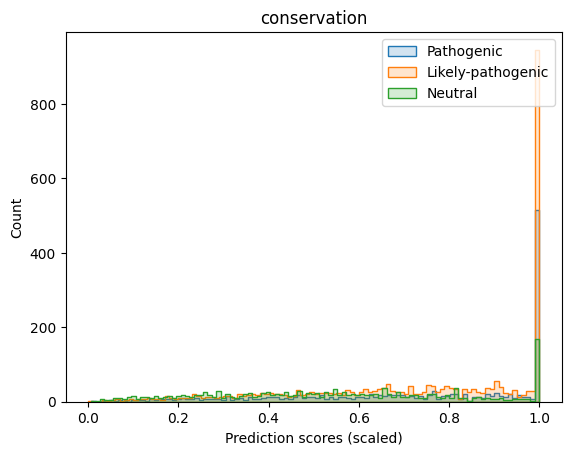

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(result_df):
    df = result_df.copy(deep=True)
    plt.cla()

    patho = result_df[result_df["class"]=="pathogenic"]
    likely_patho = result_df[result_df["class"]=="likely_pathogenic"]
    neutral = result_df[result_df["class"]=="neutral"]

    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    sns.histplot(patho["pred"], bins=bins, label=f"Pathogenic", element="step", alpha=.2)
    sns.histplot(likely_patho["pred"], bins=bins, label=f"Likely-pathogenic", element="step", alpha=.2)
    sns.histplot(neutral["pred"], bins=bins, label=f"Neutral", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/pred_scores_distribution_plots_pathogenicity_analysis/{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)


for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "esm2_t33_650M_UR50D"
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        result_df[model_pred_col] = [random.uniform(0,1) for i in range(result_df.shape[0])]

    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df, _ = get_non_nan_df(result_df, model_pred_col)
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df)
    # break

### For debugging purpose only

	AUC-ROC: 0.177
	AUC-PR: 0.808
(8302,)
	Best F1-Score: 0.769 at threshold: -0.508
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.001


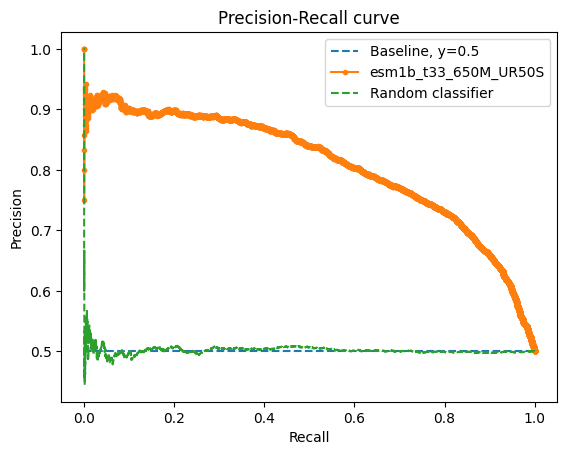

In [7]:
result_df = list_of_resut_df[0]
model_name = "esm1b_t33_650M_UR50S" # polyphen2_HVAR, esm1b_t33_650M_UR50S
model_pred_col = model_name + "_pred"

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
if not larger_means_positive_class:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

# print(thresholds.shape)
# print(precisions)
# print(recalls)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')# precisions_list.append(p)
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')


import random
result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
auc_pr_score, p, r, t = get_auc_pr_score(non_nan_result_df)
f1_max, th_max, p, r, t = get_f1max_and_th(p, r, t)
plt.plot(r, p, linestyle='--', label="Random classifier")


plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


# pathogenicity = result_df[result_df["class"]==task]
# neutral = result_df[result_df["class"]=="neutral"]

# bins = 100 # 20, 100, 500
# plt.hist(pathogenicity["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Pathogenicity-{model_name}")
# plt.hist(neutral["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Neutral-{model_name}")

# plt.legend()
# plt.show()

In [14]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df
        
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list), 0.0]

output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/avg.csv"    
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.506
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.000 at threshold: 0.001
	AUC-ROC: 0.495
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.502
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.508
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall sc